In [1]:
#tensorflow==2.2.0
#tensorflow_hub=0.8.0
#sentencepiece==0.1.91
#tqdm==4.47.0
#seaborn==0.10.1
#numpy==1.19.0

In [98]:
import tensorflow as tf 
import tensorflow_hub as hub
import sentencepiece as spm
import six

from functools import wraps
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
import string

In [99]:
hub.__version__

'0.9.0'

In [100]:
def timethis(func):
   @wraps(func)
   def wrapper(*args, **kwargs):
       start = time.time()
       result = func(*args, **kwargs)
       end = time.time()
       print(func.__name__, end-start)
       return result
   return wrapper


In [101]:
# mkdir albert_en_base
# mkdir 1
# wget https://tfhub.dev/tensorflow/albert_en_base/1https://tfhub.dev/tensorflow/albert_en_base/1
# tar-xzf albert_en_base_1.tar.gztar-xzf albert_en_base_1.tar.gz
# rm -rf albert_en_base_1.tar.gzrm -rf albert_en_base_1.tar.gz
albert_layer = hub.KerasLayer("albert_en_base/1", trainable=False)

In [102]:
#Referred from https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.pyhttps://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py
def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""
  if isinstance(text, str):
    return text
  elif isinstance(text, bytes):
    return text.decode("utf-8", "ignore")
  else:
    raise ValueError("Unsupported string type: %s" % (type(text)))

def encode_pieces(sp_model, text, sample=False):
  """Segements text into pieces.
  Args:
    sp_model: A spm.SentencePieceProcessor object.
    text: The input text to be segemented.
    sample: Whether to randomly sample a segmentation output or return a
      deterministic one.
  Returns:
    A list of token pieces.
  """
  if not sample:
    pieces = sp_model.EncodeAsPieces(text)
  else:
    pieces = sp_model.SampleEncodeAsPieces(text, 64, 0.1)
  new_pieces = []
  for piece in pieces:
    piece = printable_text(piece)
    if len(piece) > 1 and piece[-1] == "," and piece[-2].isdigit():
      cur_pieces = sp_model.EncodeAsPieces(piece[:-1].replace(
          SPIECE_UNDERLINE, ""))
      if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
        if len(cur_pieces[0]) == 1:
          cur_pieces = cur_pieces[1:]
        else:
          cur_pieces[0] = cur_pieces[0][1:]
      cur_pieces.append(piece[-1])
      new_pieces.extend(cur_pieces)
    else:
      new_pieces.append(piece)

  return new_pieces

In [103]:
@timethis
class FullSentencePieceTokenizer(object):
  """Runs end-to-end sentence piece tokenization.
  The interface of this class is intended to keep the same as above
  `FullTokenizer` class for easier usage.
  """

  def __init__(self, sp_model_file):
    """Inits FullSentencePieceTokenizer.
    Args:
      sp_model_file: The path to the sentence piece model file.
    """
    self.sp_model = spm.SentencePieceProcessor()
    self.sp_model.Load(sp_model_file)
    self.vocab = {
        self.sp_model.IdToPiece(i): i
        for i in six.moves.range(self.sp_model.GetPieceSize())
    }

  def tokenize(self, text):
    """Tokenizes text into pieces."""
    return encode_pieces(self.sp_model, text)

  def convert_tokens_to_ids(self, tokens):
    """Converts a list of tokens to a list of ids."""
    return [self.sp_model.PieceToId(printable_text(token)) for token in tokens]

  def convert_ids_to_tokens(self, ids):
    """Converts a list of ids ot a list of tokens."""
    return [self.sp_model.IdToPiece(id_) for id_ in ids]

In [104]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [105]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

In [106]:
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [107]:
sentence = "I am amazed"

In [108]:
sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = FullSentencePieceTokenizer(sp_model_file)

FullSentencePieceTokenizer 0.08099794387817383


In [109]:
stokens = tokenizer.tokenize(sentence)

In [110]:
MAX_LEN = 20

In [111]:
stokens = stokens[:MAX_LEN]
stokens = ["[CLS]"] + stokens + ["[SEP]"]

In [112]:
stokens

['[CLS]', '▁', 'I', '▁am', '▁amazed', '[SEP]']

In [113]:
MAX_LEN = 100
MAX_SEQ_LEN= MAX_LEN + 2

In [114]:
ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
masks = get_masks(stokens, MAX_SEQ_LEN)
segments = get_segments(stokens, MAX_SEQ_LEN)

In [115]:
ids

[2,
 13,
 1,
 589,
 17378,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [116]:
masks

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [117]:
segments

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [118]:
#@timethis
def create_single_input(sentence, MAX_LEN, MAX_SEQ_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

In [119]:
stokens = tokenizer.tokenize("the body is made of metallica and deliveri high tension")
stokens

['▁the',
 '▁body',
 '▁is',
 '▁made',
 '▁of',
 '▁metallic',
 'a',
 '▁and',
 '▁deliver',
 'i',
 '▁high',
 '▁tension']

In [120]:
max_seq_length = MAX_SEQ_LEN

In [121]:
@timethis
def get_model():
    input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")
    pooled_output, sequence_output = albert_layer([input_word_ids, input_mask, segment_ids])
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
    
    return model


In [122]:
albert_model = get_model()

get_model 0.07103276252746582


In [123]:
albert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 102)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 102)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]           

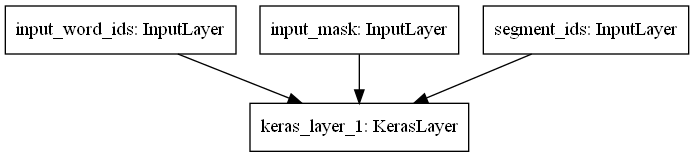

In [124]:
from tensorflow.keras.utils import plot_model
plot_model(albert_model)

In [126]:
s = "This is a nice sentence."
def get_albert_vec(s):
    stokens = tokenizer.tokenize(s)
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)
    input_ids = np.asarray(ids, dtype=np.int32).reshape(1,102)
    input_masks = np.asarray(masks, dtype=np.int32).reshape(1,102)
    input_segments = np.asarray(segments, dtype=np.int32).reshape(1,102)
    return input_ids, input_masks, input_segments
input_ids, input_masks, input_segments = get_albert_vec(s)

In [127]:
%%time
pool_embs, word_embs = albert_model.predict(
    [[input_ids, input_masks, input_segments]]
)
pool_embs.shape

Wall time: 666 ms


(1, 768)

In [128]:
word_embs.shape

(1, 102, 768)

In [163]:
#@timethis
def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []

    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_LEN, MAX_SEQ_LEN)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [tf.constant(input_ids, dtype=np.int32), 
            tf.constant(input_masks, dtype=np.int32), 
            tf.constant(input_segments, dtype=np.int32)]

In [50]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  print(corr)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0.5,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    tmp_ip = create_input_array(messages_)
    message_embeddings_, _  = albert_model.predict(tmp_ip)
    message_embeddings_  = tf.nn.l2_normalize(message_embeddings_, axis=1)
    print (message_embeddings_.shape)
    plot_similarity(messages_, message_embeddings_, 90)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


(8, 768)
[[0.9999999  0.92385906 0.89913684 0.7740363  0.9198971  0.6788113
  0.88972926 0.7068915 ]
 [0.92385906 0.9999999  0.9521428  0.74929893 0.986135   0.6410569
  0.82340205 0.66704774]
 [0.89913684 0.9521428  1.0000001  0.8435346  0.9495057  0.70469445
  0.8452057  0.72506654]
 [0.7740363  0.74929893 0.8435346  1.0000001  0.7775345  0.89348006
  0.8876196  0.9009372 ]
 [0.9198971  0.986135   0.9495057  0.7775345  1.         0.6890658
  0.8533199  0.7074714 ]
 [0.6788113  0.6410569  0.70469445 0.89348006 0.6890658  1.
  0.886397   0.9852171 ]
 [0.88972926 0.82340205 0.8452057  0.8876196  0.8533199  0.886397
  1.         0.90300155]
 [0.7068915  0.66704774 0.72506654 0.9009372  0.7074714  0.9852171
  0.90300155 1.        ]]


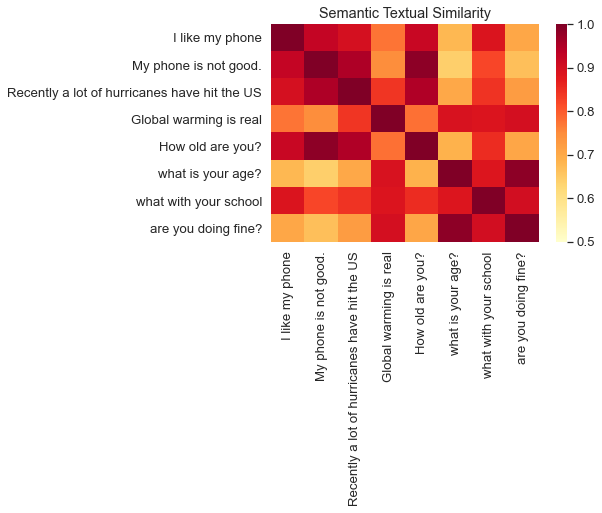

In [73]:
sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    
    # Weather
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",
    
    # Asking about age
    "How old are you?",
    "what is your age?",
    
    #how your school doing
    'what with your school',
    "are you doing fine?"
]
run_and_plot(sentences)

In [49]:
%%time
ip = create_input_array(sentences)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]

Wall time: 3.01 ms


In [50]:
%%time
pool_embs, all_embs = albert_model.predict(
    ip
)

Wall time: 373 ms


In [51]:
sentences

['I like my phone',
 'My phone is not good.',
 'Recently a lot of hurricanes have hit the US',
 'Global warming is real',
 'How old are you?',
 'what is your age?']

In [52]:
normalized_embedding  = tf.nn.l2_normalize(pool_embs, axis=1)

In [53]:
np.inner(normalized_embedding, normalized_embedding)

array([[0.9999999 , 0.92385906, 0.89913684, 0.7740363 , 0.9198971 ,
        0.6788113 ],
       [0.92385906, 0.9999999 , 0.9521428 , 0.74929893, 0.9861351 ,
        0.6410569 ],
       [0.89913684, 0.9521428 , 1.0000001 , 0.8435346 , 0.9495058 ,
        0.70469445],
       [0.7740363 , 0.74929893, 0.8435346 , 1.0000001 , 0.7775346 ,
        0.89348006],
       [0.9198971 , 0.9861351 , 0.9495058 , 0.7775346 , 1.0000002 ,
        0.68906593],
       [0.6788113 , 0.6410569 , 0.70469445, 0.89348006, 0.68906593,
        1.        ]], dtype=float32)

In [54]:
normalized_embedding.shape

TensorShape([6, 768])

In [56]:
np.inner(normalized_embedding, normalized_embedding)

array([[0.9999999 , 0.92385906, 0.89913684, 0.7740363 , 0.9198971 ,
        0.6788113 ],
       [0.92385906, 0.9999999 , 0.9521428 , 0.74929893, 0.9861351 ,
        0.6410569 ],
       [0.89913684, 0.9521428 , 1.0000001 , 0.8435346 , 0.9495058 ,
        0.70469445],
       [0.7740363 , 0.74929893, 0.8435346 , 1.0000001 , 0.7775346 ,
        0.89348006],
       [0.9198971 , 0.9861351 , 0.9495058 , 0.7775346 , 1.0000002 ,
        0.68906593],
       [0.6788113 , 0.6410569 , 0.70469445, 0.89348006, 0.68906593,
        1.        ]], dtype=float32)

In [57]:
sim_mat = np.inner(normalized_embedding, normalized_embedding)

In [59]:
word_embs.shape

(1, 22, 768)

In [60]:
pool_embs.shape

(1, 768)

In [139]:
path = "E:/LOMBA/Kaggle/Comp/Coommon readilbility/"
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [140]:
STOPWORDS = set(stopwords.words("english"))
def text_cleaning(text):
    text_clean = " ".join([word for word in word_tokenize(text) if not word in STOPWORDS])
    text = re.sub("\s+"," ", text_clean) # remove extra spaces
    text = ''.join([k for k in text if k not in string.punctuation]) # remove punctuation
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip() # remove unnecessary literals and Perform Case Normalization
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [141]:
target = train.target.to_numpy()
text = train.excerpt.to_numpy()

In [142]:
txt_clean = []
for sentence_ in text:
    clean_txt = text_cleaning(sentence_)
    txt_clean.append(clean_txt)

In [129]:
def proprocess_albert(sentence_list):
    ip = create_input_array(sentence_list)
    pool_embs, all_embs = albert_model.predict(ip)
    print (pool_embs.shape, all_embs.shape)
    normalized_embedding  = tf.nn.l2_normalize(pool_embs, axis=1)
    return all_embs

In [130]:
embed_albert = proprocess_albert(txt_clean)

100%|████████████████████████████████████████████████████████████████████████████| 2834/2834 [00:00<00:00, 3507.30it/s]


KeyboardInterrupt: 

In [95]:
n = []
for x in range(0, 22):
    n = ((embed_albert[:, x, :]))
n.shape

(2834, 768)

In [93]:
b

-0.015551242

In [73]:
embed_albert = embed_albert[:, 0, :]

In [74]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [75]:
print (embed_albert.shape)
print (target.shape)

(2834, 768)
(2834,)


In [76]:
train_x, test_x, train_y, test_y = train_test_split(np.array(embed_albert), target, test_size=0.1, shuffle=True, random_state=99)

In [81]:
#parameter settings
params = {'boosting_type': 'gbdt',
 'metrics': 'rmse',
 'objective': 'regression',
 'seed': 99,
 'learning_rate': 0.01,
 'n_jobs': -1,
 'verbose': -1}
pred = np.zeros(test.shape[0])

In [82]:
fold = KFold(5, shuffle=True, random_state=42)
cv = list(fold.split(np.array(embed_albert), target))

In [83]:
rmses = []
for tr_idx, val_idx in cv: 

    x_tr, x_va = np.array(embed_albert)[tr_idx], np.array(embed_albert)[val_idx]
    y_tr, y_va = target[tr_idx], target[val_idx]
        
    train_set = lgb.Dataset(x_tr, y_tr)
    val_set = lgb.Dataset(x_va, y_va, reference=train_set)
        
    # Training
    model = lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=100,
                      valid_sets=[train_set, val_set], verbose_eval=-1)
        
    y_pred = model.predict(x_va)
    rmse =  np.sqrt(mean_squared_error(y_va, y_pred))
    rmses.append(rmse)

        
print("\n", "Mean Fold RMSE:", np.mean(rmses))   
pd.Series(model.predict(x_va)).hist()


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1385]	training's rmse: 0.0799242	valid_1's rmse: 0.77407
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[752]	training's rmse: 0.212427	valid_1's rmse: 0.7595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[793]	training's rmse: 0.195463	valid_1's rmse: 0.795396
Training until validation scores don't improve for 100 rounds


KeyboardInterrupt: 

# Albert Base Train Model

In [170]:
import tensorflow_text as text 

In [171]:
albert_layer_train = hub.KerasLayer("albert_en_base/1", trainable=True)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")

In [135]:
def albert_base_model():
    input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")
    pooled_output, sequence_output = albert_layer_train([input_word_ids, input_mask, segment_ids])
    
    net = tf.keras.layers.Dropout(0.1)(pooled_output)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=net, name="model_albert_trainable")
    return model
albert_model = albert_base_model()
albert_model.summary()

Model: "model_albert_trainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 102)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 102)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0

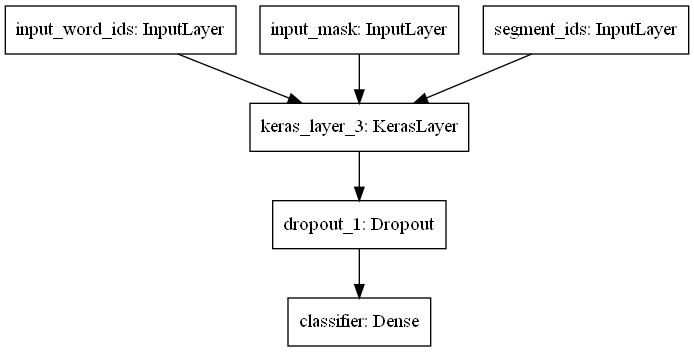

In [136]:
plot_model(albert_model)

In [137]:
loss = "mean_squared_error"
metrics = tf.keras.metrics.RootMeanSquaredError()

In [168]:
def create_single_input(sentence, MAX_LEN, MAX_SEQ_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

In [169]:
def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []

    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_LEN, MAX_SEQ_LEN)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [tf.constant(input_ids, dtype=np.int32), 
            tf.constant(input_masks, dtype=np.int32), 
            tf.constant(input_segments, dtype=np.int32)]

In [164]:
def albert_tokenizer(sentence_list):
    ip = create_input_array(sentence_list)
    return ip
tokenizer_txt = np.array(albert_tokenizer(txt_clean))
(tokenizer_txt).shape

100%|████████████████████████████████████████████████████████████████████████████| 2834/2834 [00:00<00:00, 3952.42it/s]


(3, 2834, 102)

In [143]:
train_x, test_x, train_y, test_y = train_test_split(txt_clean, target, test_size=0.1, shuffle=True, random_state=99)

In [156]:
dataset = tf.data.Dataset.range(len(train_y))
print(tf.data.experimental.cardinality(dataset).numpy())

2550


In [165]:
from official.nlp import optimization

In [166]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(tf.data.Dataset.range(len(train_y))).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [167]:
albert_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = classifier_model.fit(x=train_x,
                               validation_data=val_ds,
                               epochs=epochs)